# Design filter mixer design for adc_receiver_v0

In [71]:
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib widget
#%matplotlib qt

## Parameters of the dec16_fir filter

- 16 samples in //
- 4 taps
- coefficients represented as Q(16, 15)

In [72]:
n_inputs = 4      # Number of Simultaneous Inputs (2^?)
decimation = 2**n_inputs
TotalTaps = 3     # Total Number of Taps
PFBSize = 5       # We want the same here
alltaps = TotalTaps * 2**PFBSize
fwidth = 1

coef_w = 16
coef_dp = 15

fs = 3700
F_cut = fs/decimation/2

In [73]:
dec16_fir_coeffs = scipy.signal.firwin(alltaps, F_cut , width=None, window='hamming', pass_zero=True, scale=True, nyq=None, fs=fs)
dec16_fir_coeffs /= np.max(dec16_fir_coeffs)
#windowval = scipy.signal.windows.hamming(alltaps, sym=True)
#coeffs = windowval * np.sinc(fwidth * ((np.arange(alltaps) + 0.5)/(2**PFBSize)-TotalTaps/2))

In [74]:
def aliased_freq(f_signal, f_sample):
    n = (f_signal / float(f_sample)).round()
    f_alias = abs(f_sample * n - f_signal)
    return f_alias


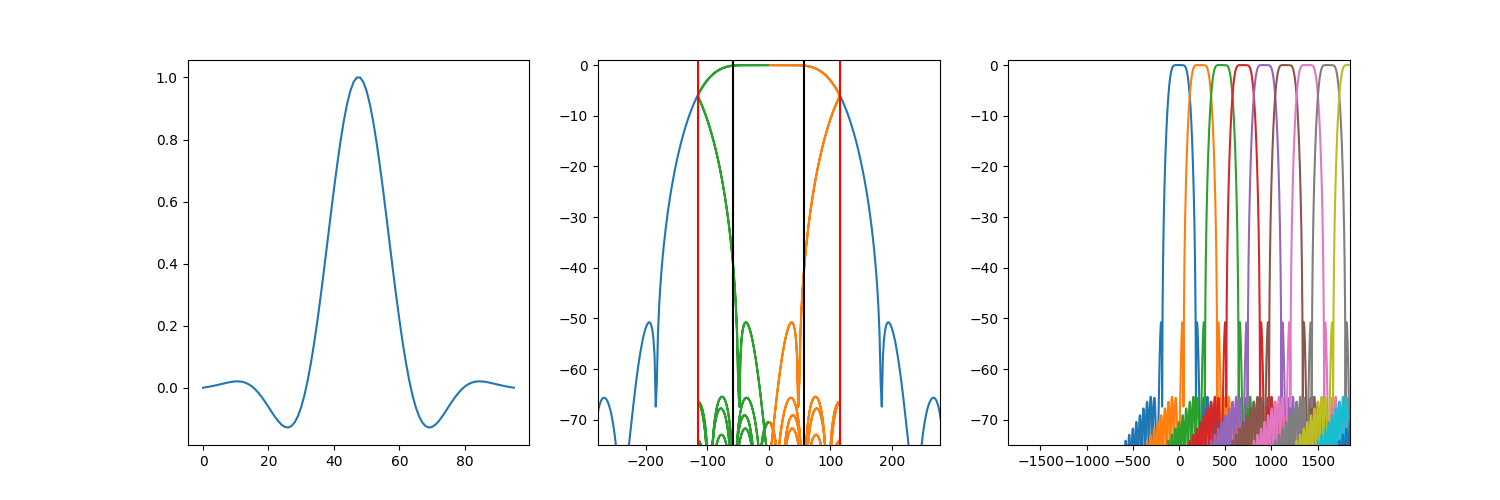

In [75]:
def plot_coeff(coeffs, fs, decimation):
    fig, axs = plt.subplots(ncols=3, figsize=(15,5))
    axs[0].plot(coeffs)

    w, h = scipy.signal.freqz(coeffs, worN=np.linspace(-fs/2,fs/2,2048), whole=True, fs=fs)
    H = 20*np.log10(abs(h))
    H -= np.max(H)
    
    axs[1].plot(w, H)
    axs[1].set_xlim((-fs/decimation*1.2, fs/decimation*1.2))
    axs[1].set_ylim((-75, 1))
    
    wa = aliased_freq(w, fs/decimation)
    axs[1].plot(wa, H)
    axs[1].plot(-wa, H)
    axs[1].axvline(-fs/decimation/2, color='r')
    axs[1].axvline(fs/decimation/2, color='r')
    axs[1].axvline(-fs/decimation/4, color='k')
    axs[1].axvline(fs/decimation/4, color='k')
  
    
    dF0 = fs / decimation
    for ch in range(0, 16):
        axs[2].plot(w+ch*dF0, H, '-')
    
    axs[2].set_xlim((-fs/2, fs/2))
    axs[2].set_ylim((-75, 1))


plot_coeff(dec16_fir_coeffs, fs, decimation)

In [76]:
dec16_fir_coeffs.tofile('dec_fir_coefs.txt', sep=', ')
print('[' + ', '.join( str(c) for c in list(dec16_fir_coeffs)) + ']')
print(dec16_fir_coeffs.shape)

[0.0008423171072776032, 0.002580263882553367, 0.004441477438301597, 0.006475731246387977, 0.008704868356864019, 0.011109467015291271, 0.01361829211949308, 0.01610177696300007, 0.018370551175320785, 0.02017971506915274, 0.021239175709447056, 0.021229929208155286, 0.01982572424755751, 0.01671910316061453, 0.011650419007184477, 0.004438098454560237, -0.004991813992781547, -0.016578914743936576, -0.03010657917341692, -0.04518691350206507, -0.06125418177206277, -0.07756797509270959, -0.09322689399839915, -0.10719294178798841, -0.11832620838600875, -0.12542879578695731, -0.12729633461625883, -0.12277490356837543, -0.11082072373851734, -0.09055968776765944, -0.061343622337858325, -0.02280018685885811, 0.025126513034276078, 0.08214717526049989, 0.14761249533787463, 0.22051375764707445, 0.2994995487933714, 0.38290852714269136, 0.46881737075202096, 0.5551022367499266, 0.639511342082314, 0.7197456588672271, 0.7935442426158124, 0.8587704061927639, 0.9134948355626751, 0.95607182392192, 0.9852050768

In [77]:
def quantize(x, w, pt, mode='round'):
    max_v = (2**(w-1) - 1) / 2**pt
    min_v = (-2**(w-1))    / 2**pt
    #print(f"[{min_v},{max_v}]")

    # normalize
    max_x = np.max(x)
    if max_x > max_v:
        x = x / max_x * max_v

    min_x = np.min(x)
    if min_x < min_v:
        x = x / min_x * min_v

    # quantize
    y = x * 2**pt
    if mode == 'round':
        y = np.round(y)
    elif mode == 'trunc':
        y = np.floor(y)
    return y / 2**pt

# x = np.arange(-1024, 1023)/1024
# plt.figure()
# plt.plot(x, quantize(x, 6), '.')
# plt.plot(x, quantize(x, 8), '.')
# plt.plot(x, quantize(x, 10), '.')


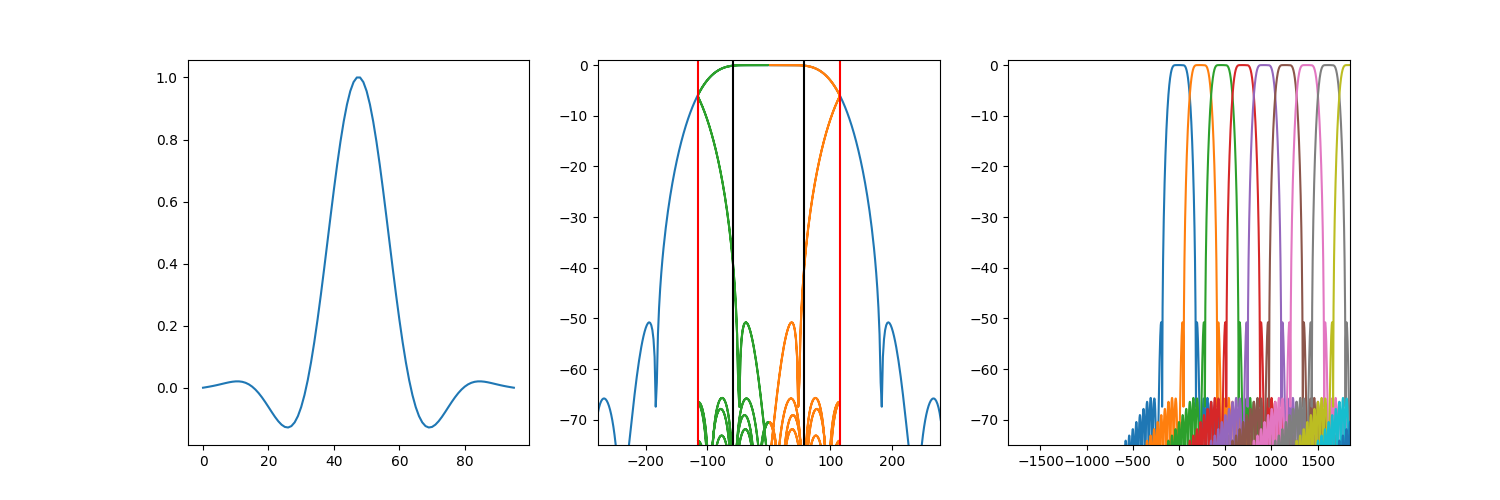

In [78]:
Q = (coef_w, coef_dp)
# Q = (6, 5)
dec16_fir_coeffs_q = quantize(dec16_fir_coeffs, Q[0], Q[1])
plot_coeff(dec16_fir_coeffs_q, fs, decimation)


In [79]:
dec16_fir_coeffs_q.tofile(f'dec_fir_coefs_Q{Q[0]}.{Q[1]}.txt', sep=', ')
print('[' + ', '.join( str(c) for c in list(dec16_fir_coeffs_q)) + ']')
print(dec16_fir_coeffs_q.shape)

[0.0008544921875, 0.002593994140625, 0.00445556640625, 0.0064697265625, 0.008697509765625, 0.0111083984375, 0.01361083984375, 0.01611328125, 0.01837158203125, 0.020172119140625, 0.021240234375, 0.021240234375, 0.01983642578125, 0.0167236328125, 0.01165771484375, 0.004425048828125, -0.0050048828125, -0.016571044921875, -0.030120849609375, -0.045196533203125, -0.061248779296875, -0.07757568359375, -0.093231201171875, -0.107177734375, -0.118316650390625, -0.12542724609375, -0.127288818359375, -0.122772216796875, -0.110809326171875, -0.090545654296875, -0.06134033203125, -0.022796630859375, 0.025115966796875, 0.0821533203125, 0.147613525390625, 0.22052001953125, 0.29949951171875, 0.382904052734375, 0.46881103515625, 0.555084228515625, 0.639495849609375, 0.7197265625, 0.79351806640625, 0.858734130859375, 0.9134521484375, 0.9560546875, 0.98516845703125, 0.999969482421875, 0.999969482421875, 0.98516845703125, 0.9560546875, 0.9134521484375, 0.858734130859375, 0.79351806640625, 0.7197265625, 0.

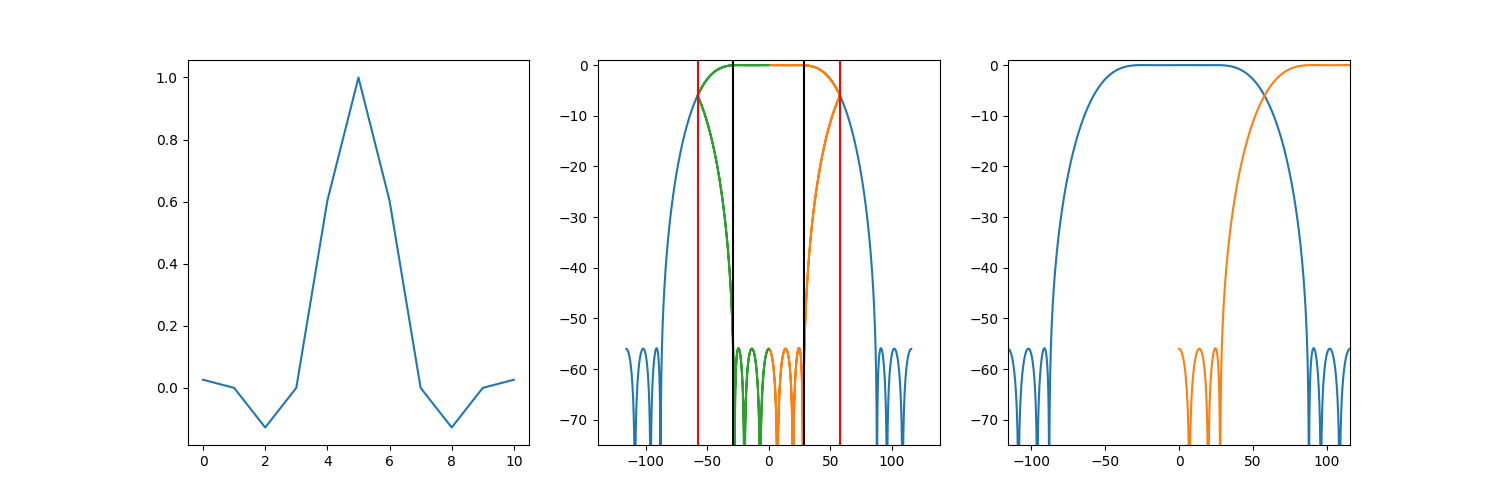

In [80]:
# ~~[Filter Design with Parks-McClellan Remez]~~
N = 10  # Filter order
# Filter symetric around 0.25 (where .5 is pi or Fs/2)
transition_band = 0.25
bands = np.array([0., .25-transition_band/2, .25+transition_band/2, .5])
h2 = scipy.signal.remez(N+1, bands, [1,0], [1,1])
h2[abs(h2) <= 1e-4] = 0.
h2 /= np.max(h2)

plot_coeff(h2, fs/16, 2)

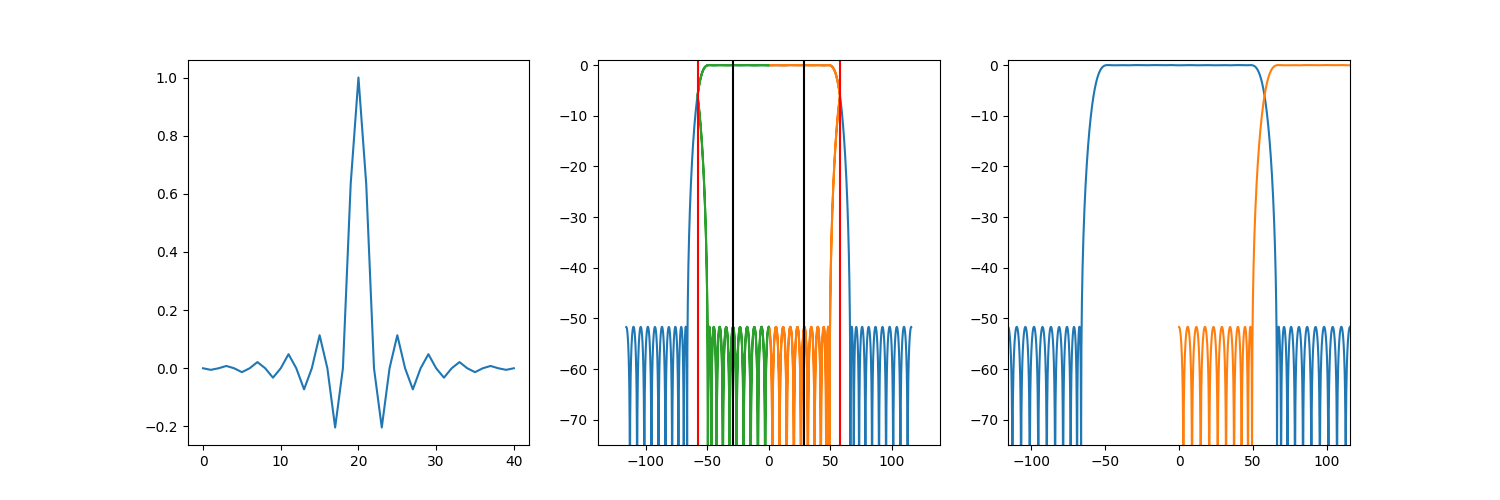

In [81]:
# ~~[Filter Design with Parks-McClellan Remez]~~
N = 40  # Filter order
# Filter symetric around 0.25 (where .5 is pi or Fs/2)
transition_band = 0.07
bands = np.array([0., .25-transition_band/2, .25+transition_band/2, .5])
h0 = scipy.signal.remez(N+1, bands, [1,0], [1,1])
h0[abs(h0) <= 1e-4] = 0.
h0 /= np.max(h0)

plot_coeff(h0, fs/16, 2)

In [82]:
def aliased_freq(f_signal, f_sample):
    neg = f_signal < 0
    n = (f_signal / float(f_sample)).round()
    f_alias = abs(f_sample * n - f_signal)
    f_alias[neg] *= -1
    return f_alias

[0.0008544921875, 0.002593994140625, 0.00445556640625, 0.0064697265625, 0.008697509765625, 0.0111083984375, 0.01361083984375, 0.01611328125, 0.01837158203125, 0.020172119140625, 0.021240234375, 0.021240234375, 0.01983642578125, 0.0167236328125, 0.01165771484375, 0.004425048828125, -0.0050048828125, -0.016571044921875, -0.030120849609375, -0.045196533203125, -0.061248779296875, -0.07757568359375, -0.093231201171875, -0.107177734375, -0.118316650390625, -0.12542724609375, -0.127288818359375, -0.122772216796875, -0.110809326171875, -0.090545654296875, -0.06134033203125, -0.022796630859375, 0.025115966796875, 0.0821533203125, 0.147613525390625, 0.22052001953125, 0.29949951171875, 0.382904052734375, 0.46881103515625, 0.555084228515625, 0.639495849609375, 0.7197265625, 0.79351806640625, 0.858734130859375, 0.9134521484375, 0.9560546875, 0.98516845703125, 0.999969482421875, 0.999969482421875, 0.98516845703125, 0.9560546875, 0.9134521484375, 0.858734130859375, 0.79351806640625, 0.7197265625, 0.

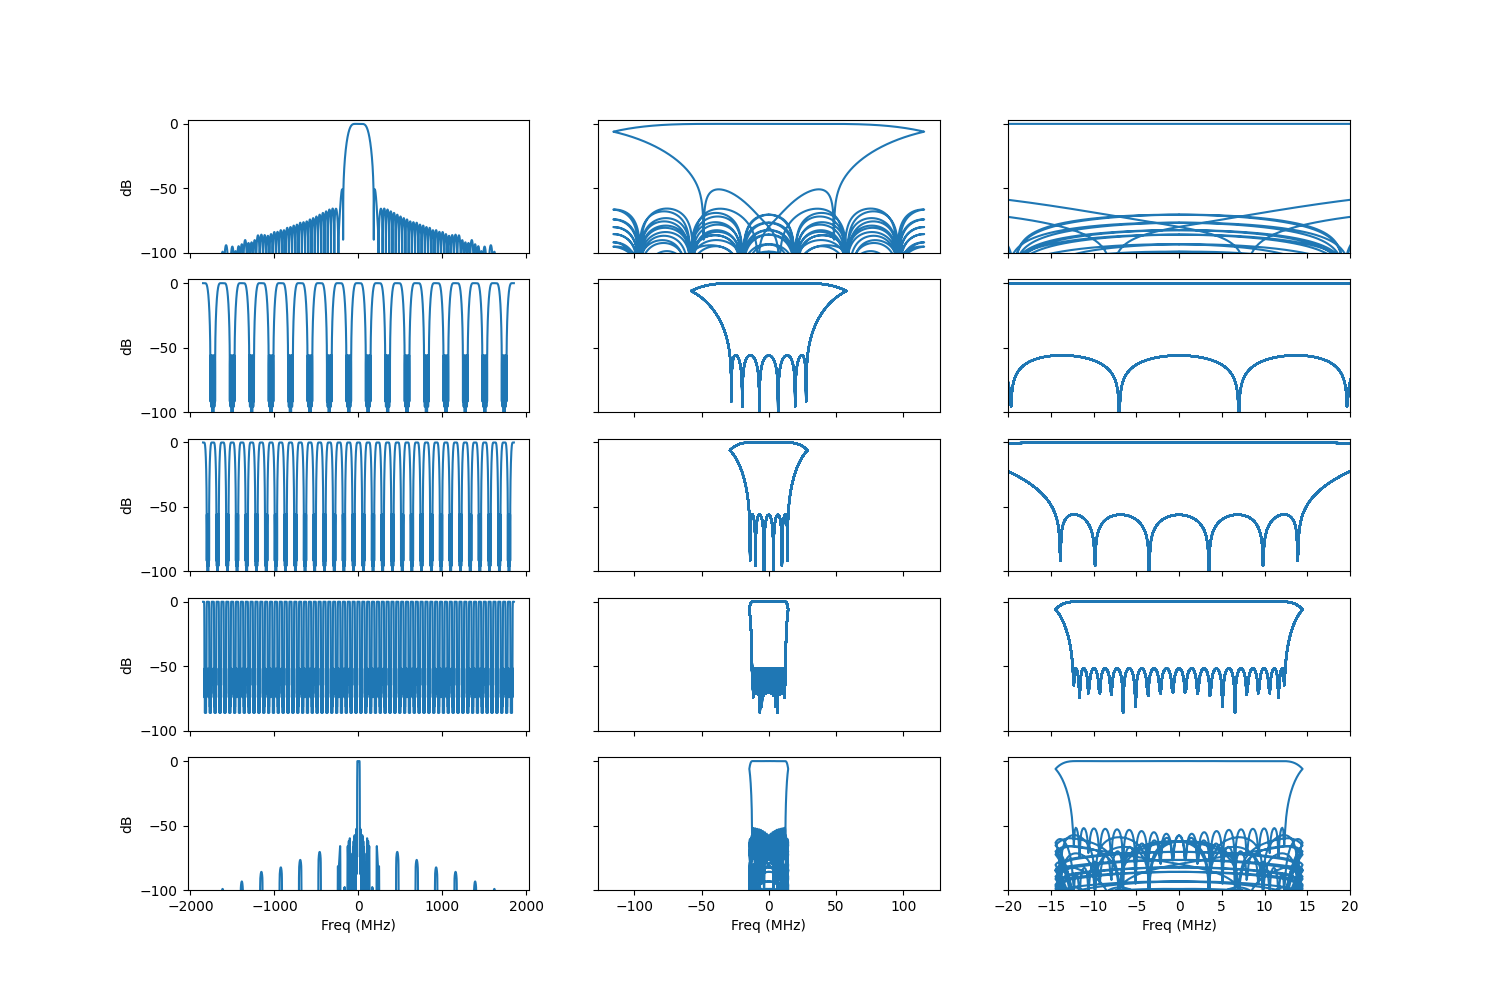

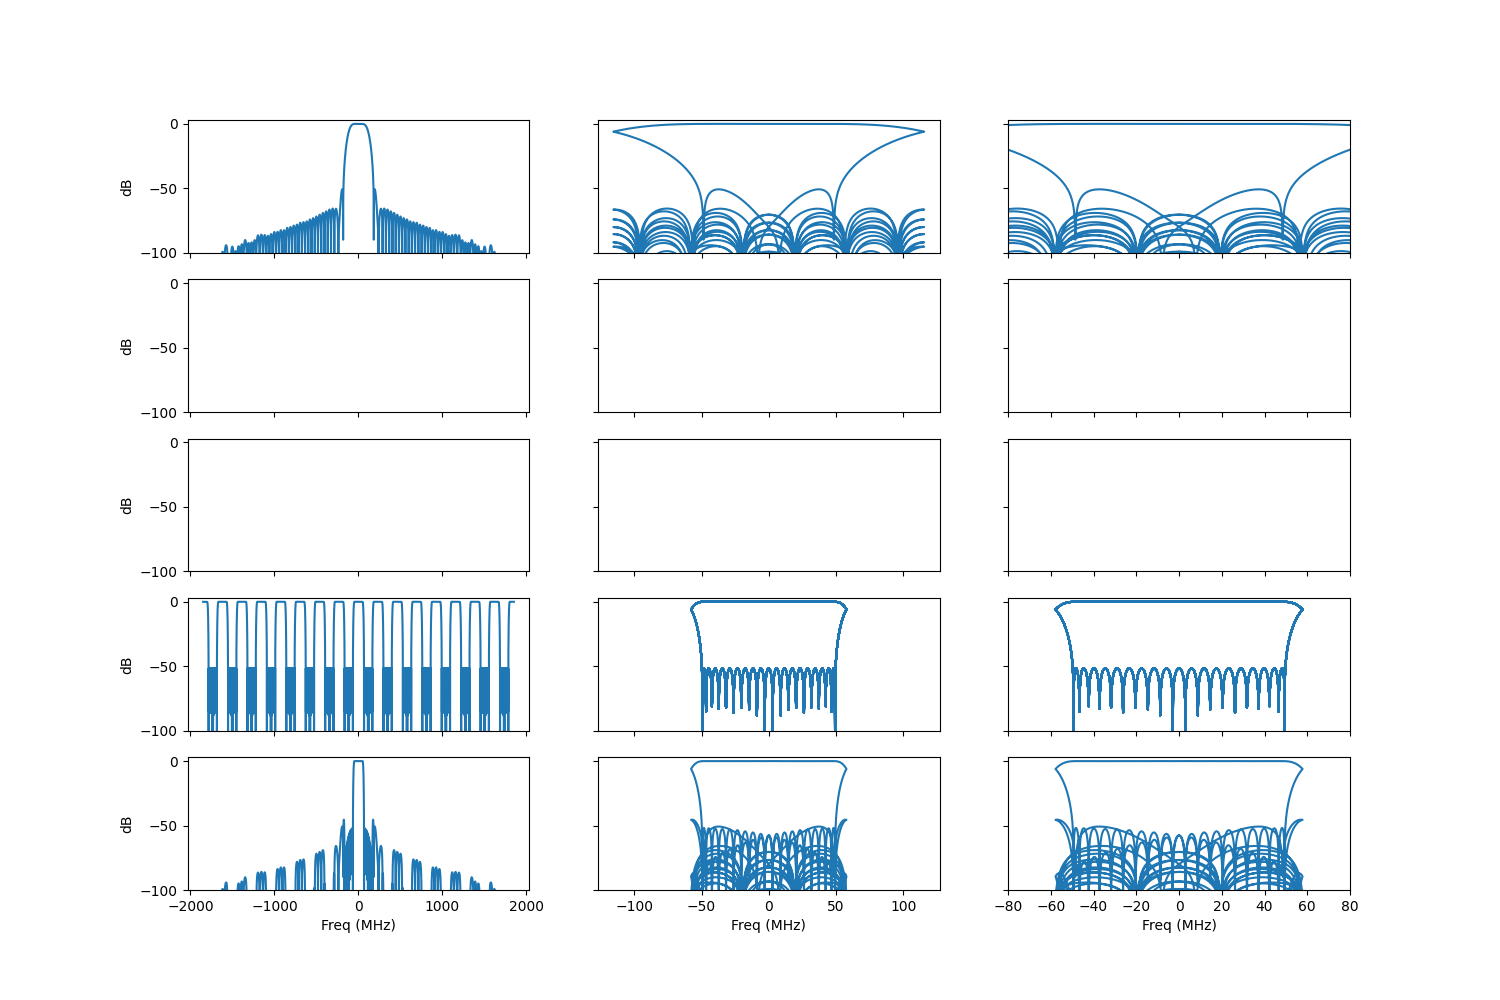

In [83]:
def plot_receiver_gain(Galactic_mode):
    Npts = 2048*16
    fs = 3700
    f = np.linspace(0, fs, Npts, endpoint=False)
    f = np.fft.fftshift(f)
    f[f>=fs/2] = f[f>=fs/2]-3700
    decimation = 1

    dec16_fir_coeffs_q = quantize(dec16_fir_coeffs, *Q)
    h2_q               = quantize(              h2, *Q)
    h0_q               = quantize(              h0, *Q)

    filters = [("dec16", dec16_fir_coeffs_q, 16, None, True),
            (   "h2",               h2_q,  2, None, Galactic_mode),
            (   "h1",               h2_q,  2, None, Galactic_mode),
            (   "h0",               h0_q,  2, None, True),
            ]

    for filter_idx in range(len(filters)):
        filter_name, filter_coeff, filter_decimation, filter_gain, active = filters[filter_idx]
        filter_coeff.tofile(f'{filter_name}_Q{Q[0]}.{Q[1]}.txt', sep=', ')
        print('[' + ', '.join( str(c) for c in list(filter_coeff)) + ']')
        print(filter_coeff.shape)
        if active:
            _, filter_gain = scipy.signal.freqz(filter_coeff, worN=f, fs=fs/decimation)
            filter_gain /= np.max(filter_gain)
            decimation *= filter_decimation
            filters[filter_idx] = (filter_name, filter_coeff, decimation, filter_gain, active)
    
    
    
    gain = np.ones_like(filter_gain)
    
    fig, axs = plt.subplots(nrows=len(filters) + 1, ncols=3,
                            sharex='col', sharey=True,
                            figsize=(15,10))
    for filter_idx in range(len(filters)):
        filter_name, filter_coeff, decimation, filter_gain, active = filters[filter_idx]
        if active:
            gain *= filter_gain
            axs[filter_idx][0].plot(f, 20*np.log10(abs(filter_gain)))
            axs[filter_idx][1].plot(aliased_freq(f, fs/decimation), 20*np.log10(abs(filter_gain)))
            axs[filter_idx][2].plot(aliased_freq(f, fs/decimation), 20*np.log10(abs(filter_gain)))
    
     
    
    axs[-1][0].plot(f, 20*np.log10(abs(gain)))
    axs[-1][1].plot(aliased_freq(f, fs/decimation), 20*np.log10(abs(gain)))
    axs[-1][2].plot(aliased_freq(f, fs/decimation), 20*np.log10(abs(gain)))
    
    axs[-1][1].set_ylim((-100, 3))
    if Galactic_mode:
        axs[-1][2].set_xlim((-20, 20))
    else:
        axs[-1][2].set_xlim((-80, 80))
    
    _=list(ax[0].set_ylabel("dB") for ax in axs)
    _=list(ax.set_xlabel("Freq (MHz)") for ax in axs[-1])
    
    
plot_receiver_gain(Galactic_mode = True)  #  28MHz BW
plot_receiver_gain(Galactic_mode = False)  # 112MHz BW


In [84]:
for filter_idx in range(len(filters)):
    filter_name, filter_coeff, filter_decimation, filter_gain, active = filters[filter_idx]
    filter_coeff.tofile(f'{filter_name}_Q{Q[0]}.{Q[1]}.txt', sep=', ')
    print('[' + ', '.join( str(c) for c in list(filter_coeff)) + ']')
    print(filter_coeff.shape)


NameError: name 'filters' is not defined